In [2]:
import ROOT

Welcome to JupyROOT 6.20/02


In [3]:
path = "/lustre/cms/store/user/adiflori/jpsikk_DataRunII_UltraLegacy_miniAODv2_v1_m4To6/Charmonium/crab_Charmonium_Run2018D-UL2018_MiniAODv2-v1_MINIAOD__1SKK_20220512_114449/220512_094551/0000/rootuple.root"

In [4]:
data = ROOT.RDataFrame("rootuple/CandidateTree", path)

In [18]:
cut = data.Filter("candidate_charge == 0").Filter("candidate_cosAlpha * candidate_cosAlpha > 0.99 * 0.99").Filter("candidate_vProb > 0.05").Filter("candidate_lxy / candidate_lxyErr > 3.0")
hist = cut.Histo1D(("candidate_vMass", "mass", 200, 5.25, 5.5), "candidate_vMass")

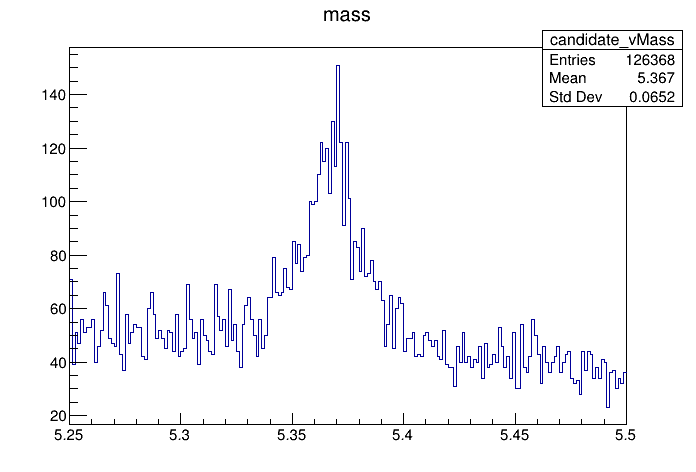

In [19]:
canvas = ROOT.TCanvas()
hist.Draw()
canvas.Draw()